In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

p = torch.zeros((1,10,1,1))

p[0,0,0,0] = 1

p

tensor([[[[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]]])

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:


args = dotdict()   

args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
args.root_path        = r"E:\datasets"

args.drop_transition  = False

args.batch_size       = 128
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.85

# Define Para

In [3]:
# 哪个数据集
args.data_name           =  "dsads"  # rw hapt

# 是否作augmentation difference
args.difference          =  False 

# 是否作augmentation  filtering
args.filtering           =  False

# 是否作augmentation  magnitude
args.magnitude           =  False
args.weighted_sampler    = False


# 是在load数据的时候  wavelet_filtering
args.wavelet_filtering   = True
args.number_wavelet_filtering = 10

args.datanorm_type       =  "standardization" # None ,"standardization", "minmax"

args.pos_select          = None
args.sensor_select       = None



args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"

config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]
args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.c_in            =  config["num_channels"]

args.input_length    =  args.windowsize
# input information
if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1

In [4]:
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [5]:
from torch.utils.data import DataLoader
print("================ {} Mode ====================".format(dataset.exp_mode))
print("================ {} CV ======================".format(dataset.num_of_cv))
for i in range(dataset.num_of_cv):
    dataset.update_train_val_test_keys()
    train_data  = data_set(args,dataset,"train")
    test_data  = data_set(args,dataset,"test")
    vali_data  = data_set(args,dataset,"vali")
    
    
        # form the dataloader
    train_data_loader = DataLoader(train_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

    vali_data_loader = DataLoader(vali_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

    test_data_loader = DataLoader(test_data,  
                                    batch_size   =  args.batch_size,
                                    shuffle      =  args.shuffle,
                                    num_workers  =  0,
                                    drop_last    =  args.drop_last)

================ LOCV Mode ====================
================ 8 CV ======================
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0027248  0.00280112 0.00284091 0.00276243 0.00282486 0.00283286
 0.00286533 0.00277778 0.00289855 0.00277778 0.00280899 0.00276243
 0.00269542 0.00280112 0.00271003 0.00274725 0.00280112 0.00298507
 0.00283286]
Train data number :  6783
The number of classes is :  19
The input_length  is :  125
The channel_in is :  45
Test data number :  1140
Validation data number :  1197
Leave one Out Experiment : The 2 Part as the test
[-] Target sampling weights:  [0.00277778 0.00291545 0.00287356 0.00280899 0.0028169  0.00276243
 0.00283286 0.0027933  0.00275482 0.0027933  0.00268817 0.00278552
 0.00287356 0.00286533 0.00271739 0.0028169  0.00277778 0.0027933
 0.0027933 ]
Train data number :  6783
The number of classes is :  19
The input_length  is :  125
The channel_in is :  45
Test data number :  1140
Validation data numbe

In [6]:
import numpy as np

In [81]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

In [82]:
from dataloaders.utils import PrepareWavelets,FiltersExtention
if args.windowsize%2==1:
    Filter_ReplicationPad1d = torch.nn.ReplicationPad1d(int((args.windowsize-1)/2))
    raw_filter = np.zeros((1,1,1,args.windowsize))
    raw_filter[0,0,0,int((args.windowsize-1)/2)] = 1
else:
    Filter_ReplicationPad1d = torch.nn.ReplicationPad1d(int(args.windowsize/2))
    raw_filter = np.zeros((1,1,1,args.windowsize))
    raw_filter[0,0,0,int(args.windowsize/2)] = 1
raw_filter = torch.tensor(raw_filter)
SelectedWavelet = PrepareWavelets(K=args.number_wavelet_filtering, length=args.windowsize)
ScaledFilter = FiltersExtention(SelectedWavelet)

ScaledFilter = torch.cat((raw_filter,ScaledFilter),0)


In [83]:
data_x = sample_x_1.T
data_x = np.expand_dims(data_x,axis=0)
data_x = torch.tensor(data_x)
data_x = Filter_ReplicationPad1d(data_x)
data_x = data_x[0]
data_x = data_x.repeat(1,1,1)[:,:,:,None]
data_x = data_x.permute([0,3,1,2])
data_x = torch.nn.functional.conv2d(data_x, ScaledFilter, padding='valid')[0,:,:,:args.windowsize]
data_x_1 = data_x.permute(0,2,1)

In [84]:
import matplotlib.pyplot as plt

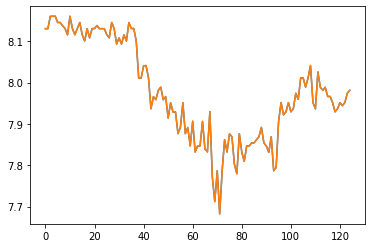

In [86]:
plt.plot(sample_x_1[:,0])
plt.plot(data_x_1[0,:,0])

In [87]:
data_x = sample_x_2.T
data_x = np.expand_dims(data_x,axis=0)
data_x = torch.tensor(data_x)
data_x = Filter_ReplicationPad1d(data_x)
data_x = data_x[0]
data_x = data_x.repeat(1,1,1)[:,:,:,None]
data_x = data_x.permute([0,3,1,2])
print(data_x.shape)
data_x = torch.nn.functional.conv2d(data_x, ScaledFilter, padding='valid')[0,:,:,:args.windowsize]

data_x_2 = data_x.permute(0,2,1)

torch.Size([1, 1, 45, 249])


In [88]:
temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).float()
print(combined_x.shape)

torch.Size([2, 1, 125, 45])


In [89]:
wave = learnable_filter(args)
out = wave(combined_x)

In [93]:
for n,p in wave.named_parameters():
    print(n)

wavelet_conv.weight


In [90]:
data_x_2.shape

torch.Size([41, 125, 45])

In [91]:
out.shape

torch.Size([2, 41, 125, 45])

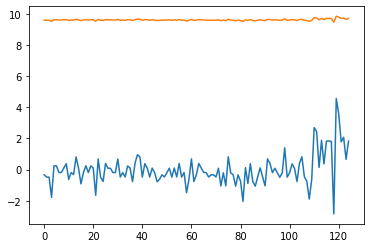

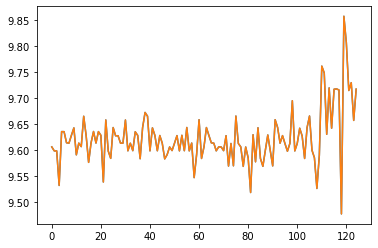

In [92]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0
plt.figure()
plt.plot(out[1,index1,:,index2])
plt.plot(data_x_2[0,:,index2])
plt.figure()
plt.plot(data_x_2[index1,:,index2])
plt.plot(data_x_2[0,:,index2])

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataloaders.utils import PrepareWavelets,FiltersExtention

class learnable_filter(nn.Module):
    def __init__(self, args):
        super(learnable_filter, self).__init__()
        self.args = args
        if args.windowsize%2==1:
            self.Filter_ReplicationPad2d = nn.ReplicationPad2d((int((args.windowsize-1)/2),int((args.windowsize-1)/2),0,0))
        else:
            self.Filter_ReplicationPad2d = nn.ReplicationPad2d((int(args.windowsize/2),int(args.windowsize/2),0,0))
                                                               

        SelectedWavelet = PrepareWavelets(K=args.number_wavelet_filtering, length=args.windowsize)
        ScaledFilter = FiltersExtention(SelectedWavelet)
        
        self.wavelet_conv = nn.Conv2d(1, ScaledFilter.shape[0], 
                                      (1,ScaledFilter.shape[3]),
                                      stride=1, bias=False, padding='valid') 
        # TODO shut down
        self.wavelet_conv.weight.data.copy_(ScaledFilter)                                        
        self.wavelet_conv.weight.requires_grad = False 
        
        self.layer_norm = nn.LayerNorm(args.windowsize, elementwise_affine=False)
                                                               
    def forward(self,x):
        x1 = x.permute(0,1,3,2)
        x1 = self.Filter_ReplicationPad2d(x1)
        x1 = self.wavelet_conv(x1)[:,:,:,:self.args.windowsize]
        x1 = x1.permute(0,1,3,2)
        x  = torch.cat((x,x1),1)
        x = self.layer_norm(x.permute(0,1,3,2)).permute(0,1,3,2)
        
        return x

In [5]:
dataset.data_x

,sub_id,acc_x_hand,acc_y_hand,acc_z_hand,gyro_x_hand,gyro_y_hand,gyro_z_hand,acc_x_chest,acc_y_chest,acc_z_chest,gyro_x_chest,gyro_y_chest,gyro_z_chest,acc_x_ankle,acc_y_ankle,acc_z_ankle,gyro_x_ankle,gyro_y_ankle,gyro_z_ankle,sub
0,1,2.37223,8.60074,3.51048,-0.092217,0.056812,-0.015845,0.238080,9.80003,-1.688960,-0.005065,-0.006781,-0.005663,9.65918,-1.655690,-0.099797,0.008300,0.009250,-0.017580,1
1,1,2.07473,8.52853,3.66021,-0.002352,0.032810,-0.003747,0.388697,9.53572,-1.724100,0.007513,-0.010498,-0.020684,9.58814,-1.770400,0.054545,0.003175,-0.020301,0.011275,1
2,1,2.33738,8.82900,3.54767,-0.023704,-0.031518,-0.047883,0.323161,9.68891,-1.377290,0.018062,0.002878,-0.030669,9.73474,-1.732420,-0.059956,-0.031973,-0.053934,0.015594,1
3,1,2.25966,9.09415,3.43015,0.007627,-0.057759,-0.019075,0.234051,9.57333,-1.804460,-0.017648,-0.000126,-0.010833,9.73624,-1.656800,-0.021820,0.007649,-0.013923,0.014498,1
4,1,2.44995,8.71431,3.54974,-0.028008,-0.048661,-0.030109,0.354014,9.53662,-1.608570,0.020264,0.054580,-0.032568,9.62226,-1.769680,-0.060878,0.040113,-0.035645,-0.006889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957506,9,-5.34317,9.58716,5.20049,0.891945,0.869740,1.283330,2.675720,9.15231,-1.642700,-0.010627,-0.248182,0.008903,9.31006,-1.248320,-3.231660,-0.135172,-0.024265,-0.057659,9
957507,9,-5.12204,9.16740,5.12824,0.847170,0.678108,1.217230,3.324710,9.11289,-1.592090,-0.163963,-0.345680,-0.007478,9.49967,-0.984048,-3.192770,-0.046738,-0.105825,-0.091276,9
957508,9,-4.88664,8.24912,4.48058,1.327620,0.362557,1.203300,3.153660,9.86177,-2.294600,-0.152650,-0.422125,-0.032787,9.85023,-1.093580,-3.998870,-0.119020,-0.016952,-0.148926,9
957509,9,-4.99389,9.88004,4.31952,1.868770,0.139438,1.016820,3.213170,10.90000,0.916941,0.318422,-0.277092,-0.160663,9.17659,-0.035269,-2.893250,-0.045662,0.011414,-0.139014,9


In [7]:
dataset.data_x.isna().sum()#[dataset.data_x["acc_x_2"].isna()]

sub_id          0
acc_x_hand      0
acc_y_hand      0
acc_z_hand      0
gyro_x_hand     0
gyro_y_hand     0
gyro_z_hand     0
acc_x_chest     0
acc_y_chest     0
acc_z_chest     0
gyro_x_chest    0
gyro_y_chest    0
gyro_z_chest    0
acc_x_ankle     0
acc_y_ankle     0
acc_z_ankle     0
gyro_x_ankle    0
gyro_y_ankle    0
gyro_z_ankle    0
sub             0
dtype: int64